/tmp/ipython-input-1932340494.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([ticker_1, ticker_2], start=start_date, end=end_date)
[*********************100%***********************]  2 of 2 completed

Data successfully loaded. Sample:
Ticker            AMD       NVDA
Date                            
2023-01-03  64.019997  14.300684
2023-01-04  64.660004  14.734248
2023-01-05  62.330002  14.250735
2023-01-06  63.959999  14.844140
2023-01-09  67.239998  15.612369

Cointegration P-Value: 0.9852



/tmp/ipython-input-1932340494.py:59: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['Signal'] = df['Signal'].replace(to_replace=0, method='ffill')


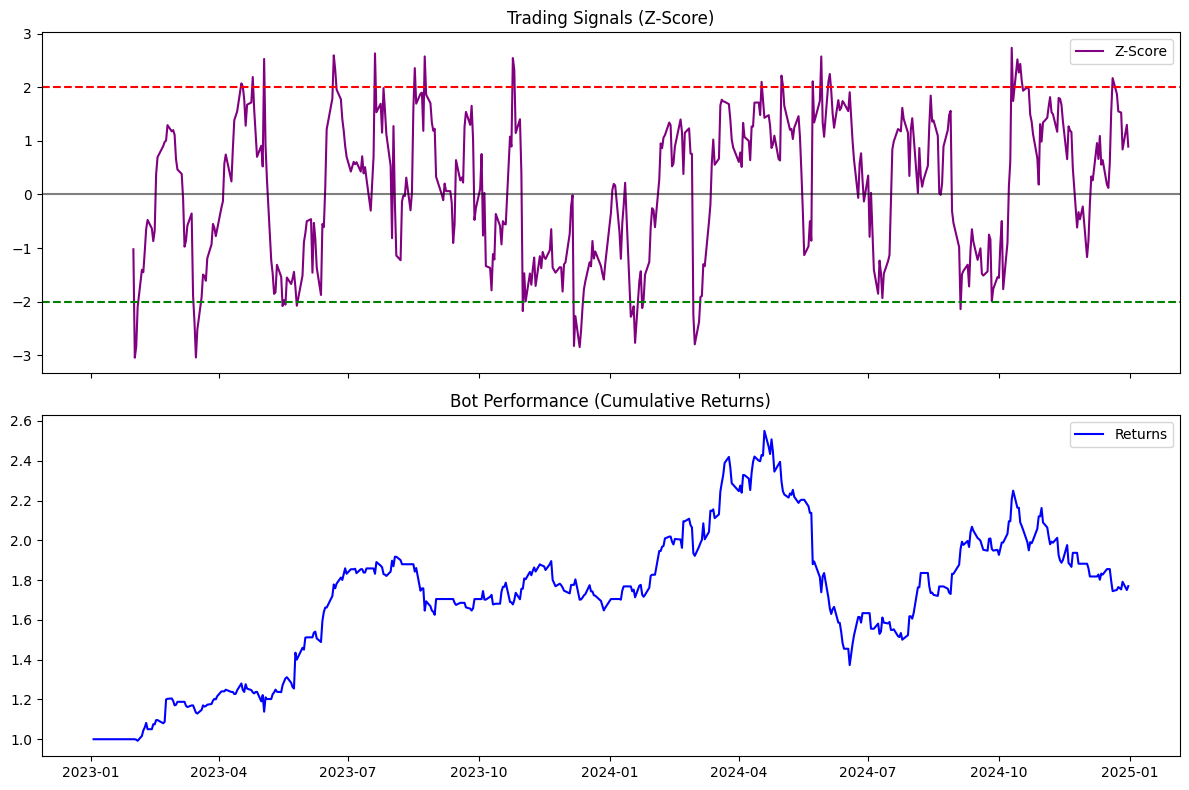

Final Strategy Return: 76.98%


In [2]:
!pip install yfinance statsmodels -q

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# --- 1. SETTINGS ---
ticker_1 = 'NVDA'
ticker_2 = 'AMD'
start_date = '2023-01-01'
end_date = '2025-01-01'

print(f"Downloading data...")

# Download specifically the 'Close' column for both
data = yf.download([ticker_1, ticker_2], start=start_date, end=end_date)

# Check if data is empty to avoid the ValueError
if data.empty:
    print("Error: No data downloaded. Check your internet or tickers.")
else:
    # Use only the Close prices and flatten the columns
    df = data['Close'].copy()
    df.dropna(inplace=True)

    print("Data successfully loaded. Sample:")
    print(df.head())

    # --- 2. COINTEGRATION TEST ---
    score, p_value, _ = coint(df[ticker_1], df[ticker_2])
    print(f"\nCointegration P-Value: {p_value:.4f}")

    # --- 3. CALCULATE THE SPREAD & Z-SCORE ---
    # Regression to find the hedge ratio
    X = sm.add_constant(df[ticker_2])
    model = sm.OLS(df[ticker_1], X).fit()
    hedge_ratio = model.params[ticker_2]

    df['Spread'] = df[ticker_1] - (hedge_ratio * df[ticker_2])

    window = 20
    df['Mean'] = df['Spread'].rolling(window=window).mean()
    df['Std'] = df['Spread'].rolling(window=window).std()
    df['Z-Score'] = (df['Spread'] - df['Mean']) / df['Std']

    # --- 4. GENERATE TRADING SIGNALS ---
    entry_threshold = 2.0
    exit_threshold = 0.0

    df['Signal'] = 0
    df.loc[df['Z-Score'] > entry_threshold, 'Signal'] = -1 # Short NVDA, Long AMD
    df.loc[df['Z-Score'] < -entry_threshold, 'Signal'] = 1  # Long NVDA, Short AMD

    # Simple logic to stay in trade until it hits the mean (0)
    # This keeps the signal active until reversion
    df['Signal'] = df['Signal'].replace(to_replace=0, method='ffill')
    df.loc[np.abs(df['Z-Score']) < 0.5, 'Signal'] = 0

    # --- 5. BACKTESTING ---
    df['Ret_1'] = df[ticker_1].pct_change()
    df['Ret_2'] = df[ticker_2].pct_change()

    # The strategy return is the difference in returns weighted by the hedge
    df['Strategy_Ret'] = (df['Ret_1'] - (hedge_ratio * df['Ret_2'])) * df['Signal'].shift(1)
    df['Cum_Ret'] = (1 + df['Strategy_Ret'].fillna(0)).cumprod()

    # --- 6. VISUALIZATION ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot Z-Score
    ax1.plot(df['Z-Score'], label='Z-Score', color='purple')
    ax1.axhline(entry_threshold, color='red', linestyle='--')
    ax1.axhline(-entry_threshold, color='green', linestyle='--')
    ax1.axhline(0, color='black', alpha=0.5)
    ax1.set_title('Trading Signals (Z-Score)')
    ax1.legend()

    # Plot Performance
    ax2.plot(df['Cum_Ret'], label='Returns', color='blue')
    ax2.set_title('Bot Performance (Cumulative Returns)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"Final Strategy Return: {((df['Cum_Ret'].iloc[-1] - 1) * 100):.2f}%")
